# Use pretrained models of scVI-hub for CELLxGENE

This notebook was contributed by Can Ergen and Martin Kim.

Original article:
`Scvi-hub: an actionable repository for model-driven single cell analysis`

https://www.biorxiv.org/content/10.1101/2024.03.01.582887

The anndata object we're using here is a subset of the full CELLxGENE census data. Use: s3://cellxgene-contrib-public/models/scvi/2024-02-12/mus_musculus/adata_minified.h5ad

**Steps performed**:

1. Loading the minified data from AWS
2. Setting up minified model with minified data
3. Visualize the latent space
4. Perform differential expression and visualize with interactive volcano plot and heatmap using Plotly

This notebook was designed to be run in Google Colab.

```{note}
Running the following cell will install tutorial dependencies on Google Colab only. It will have no effect on environments other than Google Colab.
```

In [1]:
!pip install --quiet scvi-colab
!pip install --quiet cellxgene-census
!pip install --quiet pybiomart
from scvi_colab import install

install()

/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/scvi_colab/_core.py:42: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import ContextualVersionConflict
/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/scvi_colab/_core.py:47: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [2]:
import os
import tempfile

import botocore
import cellxgene_census
import numpy as np
import plotnine as p9
import scanpy as sc
import scvi
import seaborn as sns
import torch
from scvi.hub import HubModel

In [3]:
scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)

Seed set to 0


Last run with scvi-tools version: 1.4.2


```{note}
You can modify `save_dir` below to change where the data files for this tutorial are saved.
```

In [4]:
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

We download a toy example here (all cells from the spinal cord). To download the full census use backup_url: https://cellxgene-contrib-public.s3.amazonaws.com/models/scvi/2024-02-12/homo_sapiens/adata_minified.h5ad. Expect that the download of the full census takes ~30 minutes with a high bandwidth internet connection.

We share models for mouse at https://cellxgene-contrib-public.s3.amazonaws.com/models/scvi/2024-02-12/mus_musculus (same folder structure).

In [5]:
adata_path = os.path.join(save_dir.name, "adata-spinal-cord-minified.h5ad")

adata = sc.read(
    adata_path,
    backup_url="https://cellxgene-contrib-public.s3.amazonaws.com/models/scvi/2024-02-12/homo_sapiens/adata-spinal-cord-minified.h5ad",
)

model = HubModel.pull_from_s3(
    s3_bucket="cellxgene-contrib-public",
    s3_path="models/scvi/2024-02-12/homo_sapiens/modelhub",
    pull_anndata=False,
    config=botocore.config.Config(signature_version=botocore.UNSIGNED),
)

adata, model

  0%|          | 0.00/45.1M [00:00<?, ?B/s]

HubModel with:
local_dir: /tmp/tmp84uddqqb
model loaded? No
adata loaded? No
large_training_adata loaded? No
metadata:
HubMetadata(scvi_version='1.0.4', anndata_version='0.8.0', model_cls_name='SCVI', training_data_url=None, model_parent_module='scvi.model')
model_card:


-------------------------------------------------------------------------------------------------------------------

license: cc-by-4.0                                                                                                 

library_name: scvi-tools                                                                                           

tags:                                                                                                              

 • biology                                                                                                         
 • genomics                                                                                                        
 • single-cell                                                                                                     
 • model_cls_name:SCVI                                                                                             
 • scvi_version:1.0.4                                                                                              
 • anndata_version:0.8.0                                                                                           

-------------------------------------------------------------------------------------------------------------------

                                                    Description                                                    

SCVI model trained on the homo_sapiens data of the CELLxGENE Discover Census.                                      

                                                 Model properties                                                  

Many model properties are in the model tags. Some more are listed below.                                           

model_init_params:                                                                                                 

                                                                                                                   
                                                                                                                   
 {                                                                                                                 
                                                                                                                   
     "n_hidden": 128,                                                                                              
                                                                                                                   
     "n_latent": 50,                                                                                               
                                                                                                                   
     "n_layers": 2,                                                                                                
                                                                                                                   
     "dropout_rate": 0.1,                                                                                          
                                                                                                                   
     "dispersion": "gene",                                                                                         
                                                                                                                   
     "gene_likelihood": "nb",                                                                                      
                                                                                                                   
     "latent_distribution": "normal",                                                                              
                                                                                                                   
     "encode_covariates": false              

(AnnData object with n_obs × n_vars = 117463 × 8000
     obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars', 'batch', '_scvi_batch', '_scvi_labels', '_scvi_observed_lib_size'
     var: 'soma_joinid', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'
     uns: '_scvi_adata_minify_type', '_scvi_manager_uuid', '_scvi_uuid'
     obsm: '_scvi_latent_qzm', '_scvi_latent_qzv',
 )

### Setup minified model

Census was trained on all primary cells. We don't encode covariates so inference and generating latent codes works without retraining on these batches. We have to subset to all training batches.
The setup will be optimized in a future version of scvi-tools.

In [6]:
del adata.uns["_scvi_adata_minify_type"]
model.load_model(adata=adata[adata.obs["is_primary_data"]].copy())
census_model = model.model

INFO     Loading model...                                                                                          
INFO     File /tmp/tmp84uddqqb/model.pt already downloaded                                                         


In [7]:
census_model_all = scvi.model.SCVI.load_query_data(adata, census_model)

/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 6006 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.


For spinal cord less than a half of cells is labeled as primary cells, while the other cells are duplicated from this dataset. census_model_all contains all cells while census_model only contains primary cells.

In [8]:
adata.obs["is_primary_data"].value_counts()

is_primary_data
False    67707
True     49756
Name: count, dtype: int64

In [9]:
census_model.adata, census_model_all.adata

(AnnData object with n_obs × n_vars = 49756 × 8000
     obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'development_stage', 'development_stage_ontology_term_id', 'disease', 'disease_ontology_term_id', 'donor_id', 'is_primary_data', 'self_reported_ethnicity', 'self_reported_ethnicity_ontology_term_id', 'sex', 'sex_ontology_term_id', 'suspension_type', 'tissue', 'tissue_ontology_term_id', 'tissue_general', 'tissue_general_ontology_term_id', 'raw_sum', 'nnz', 'raw_mean_nnz', 'raw_variance_nnz', 'n_measured_vars', 'batch', '_scvi_batch', '_scvi_labels', '_scvi_observed_lib_size'
     var: 'soma_joinid', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'
     uns: '_scvi_manager_uuid', '_scvi_uuid'
     obsm: '_scvi_latent_qzm', '_scvi_latent_qzv',
 AnnData object with n_obs × n_vars = 117463 × 8000
     obs: 'soma_joinid', 'dataset_id', 'assay', 'assay_ontology_term_id', 'cell_type', 'cell_type_ontology_term_id', 'deve

By default scvi-tools loads models as not minified. We set up the model here with minified data, so we minify the model using the respective obsm fields.

In [10]:
census_model.minify_adata(
    use_latent_qzm_key="_scvi_latent_qzm", use_latent_qzv_key="_scvi_latent_qzv"
)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


### Get the latent space and compute UMAP

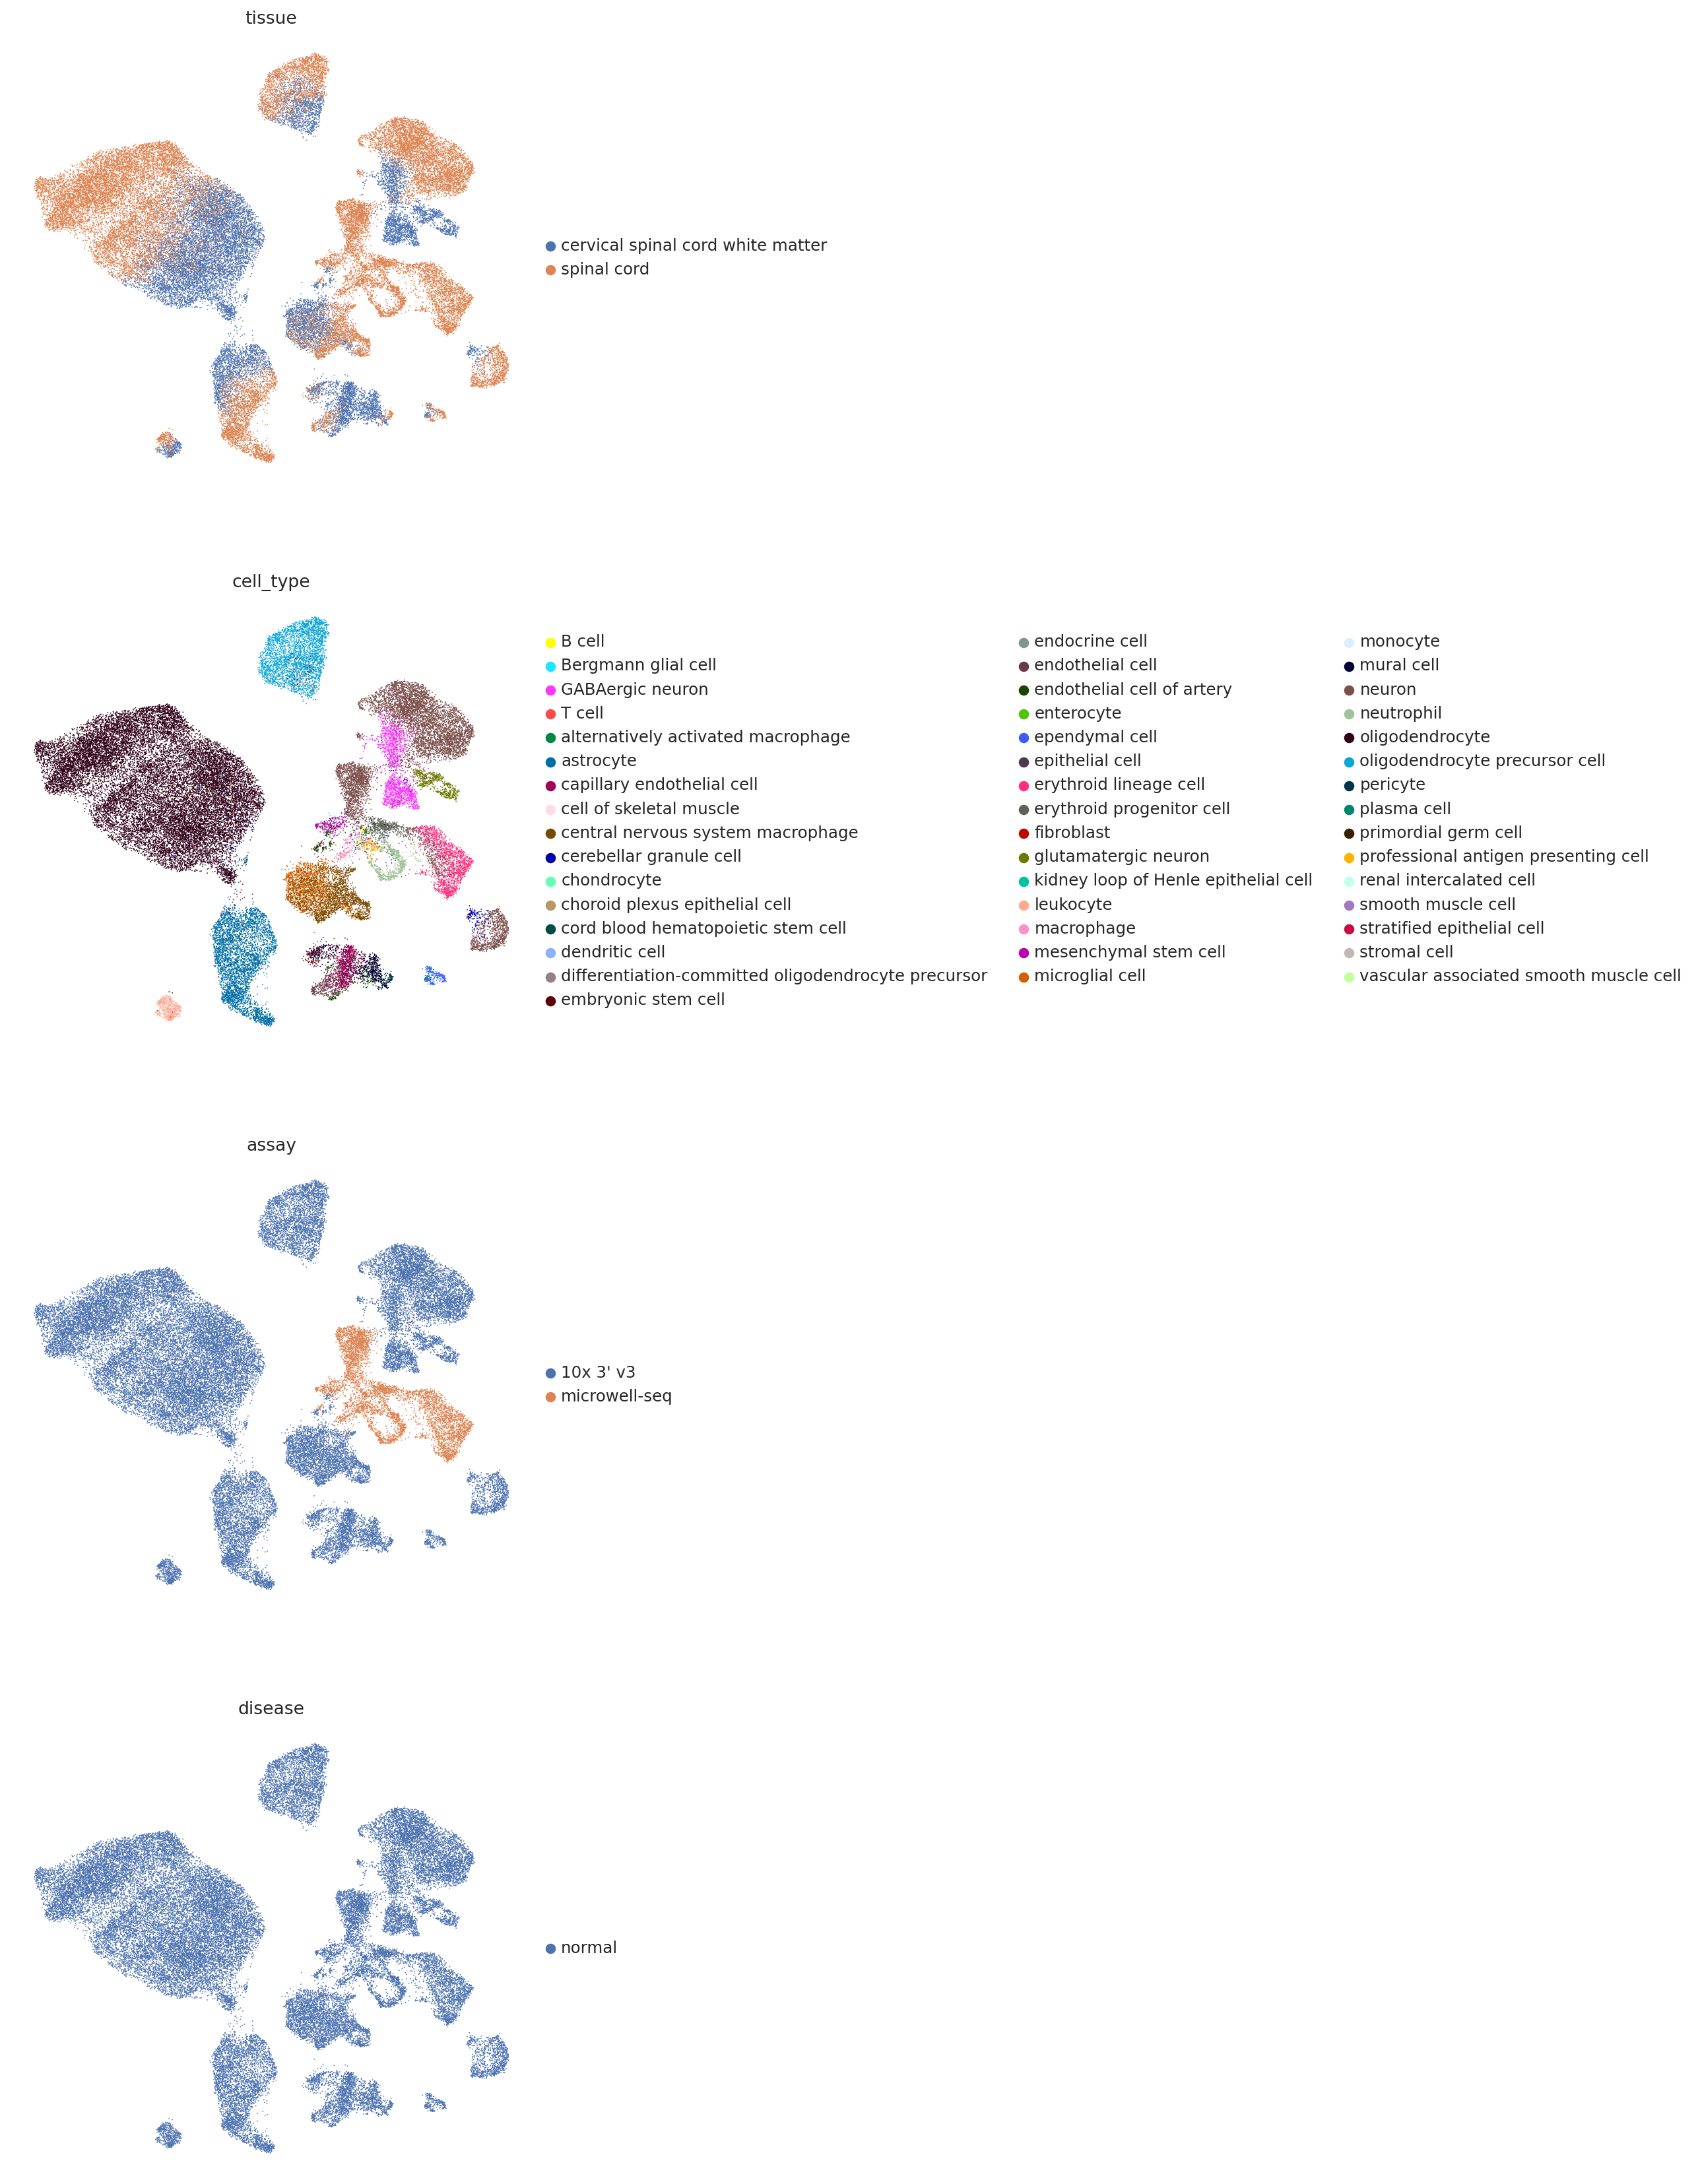

In [11]:
sc.pp.neighbors(census_model.adata, n_neighbors=20, use_rep="_scvi_latent_qzm")
sc.tl.umap(census_model.adata)
sc.pl.umap(census_model.adata, color=["tissue", "cell_type", "assay", "disease"], ncols=1)

## Performing Differential Expression in scVI

While we only have access to the minified data, we can still perform downstream analysis using the generative part of the model.

Differential expression (DE) analysis is used to quantify the differences in gene expression across subpopulations of genes.
If we have two sets of cells $A$ and $B$, a DE test is typically used to predict two things for each gene:

1. Whether the gene's expression levels are significantly different in the A and B sets of cells.
2. An effect size that quantifies the strength of the differential expression.

Once trained, scVI can natively perform both of these tasks.
Additionally, its differential expression module can account for batch effects and filter DE genes expected to be of little relevance.

### Selecting cell subpopulations to compare

In [12]:
# let's take a look at abundances of different cell types
print(
    census_model.adata.obs["cell_type"].value_counts(),
    "\n\n\n\n",
    census_model.adata.obs["tissue"].value_counts(),
)

cell_type
oligodendrocyte                                        20708
neuron                                                  7831
astrocyte                                               4449
oligodendrocyte precursor cell                          3191
microglial cell                                         1864
GABAergic neuron                                        1790
central nervous system macrophage                       1777
erythroid lineage cell                                  1684
capillary endothelial cell                               915
mural cell                                               879
neutrophil                                               708
erythroid progenitor cell                                606
glutamatergic neuron                                     576
leukocyte                                                542
endothelial cell of artery                               330
endothelial cell                                         247
mesenchymal st

scVI provides several options to identify the two populations of interest.

In [13]:
cell_type = "oligodendrocyte"
tissue1 = "spinal cord"
cell_idx1 = np.logical_and(
    census_model.adata.obs["cell_type"] == cell_type,
    census_model.adata.obs["tissue"] == tissue1,
)
print(sum(cell_idx1), "cells from tissue", tissue1)

tissue2 = "cervical spinal cord white matter"
cell_idx2 = np.logical_and(
    census_model.adata.obs["cell_type"] == cell_type,
    census_model.adata.obs["tissue"] == tissue2,
)
print(sum(cell_idx2), "cells of type", tissue2)

# or equivalently, provide a string of the form "my_celltype_column == 'desired_celltype'"
# cell_idx1 = "cell_type == 'Ciliated_non_amphid_neuron'"
# cell_idx2 = "cell_type == 'Intestine'"

11547 cells from tissue spinal cord
9161 cells of type cervical spinal cord white matter


### Running DE analyses

A simple DE analysis can then be performed using the following command

In [16]:
de_change = census_model.differential_expression(
    idx1=cell_idx1, idx2=cell_idx2, all_stats=False, mode="change"
)

/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/scvi/model/base/_rnamixin.py:429: UserWarning: Count statistics make no sense for minified model. Consider disabling all_stats.


DE...:   0%|          | 0/1 [00:00<?, ?it/s]

This method returns a pandas DataFrame, where each row corresponds to a gene.
The most important columns of this dataframe are the following.
**proba_de**, which captures the posterior probability of $M_{2, g}$ that the gene is differentially expressed. Values close to one indicate that the gene is DE;
**lfc_mean** and **lfc_median**, respectively denoting the mean and the median of the posterior distribution of $\beta_g$. Positive values of the LFC signify that the gene is upregulated in `idx1`;
**is_de_fdr_0.05** is `True` when the gene is tagged DE after FDR correction at target level $\alpha=0.05$. The target level can be adjusted by specifying `fdr_target` in the `differential_expression` method.

### Volcano plot with p-values

In [17]:
de_change["log10_pscore"] = np.log10(de_change["proba_not_de"] + 1e-6)
de_change = de_change.join(census_model.adata.var, how="inner")
de_change = de_change.loc[np.max(de_change[["scale1", "scale2"]], axis=1) > 1e-4]
de_change["feature_id"] = de_change.index
de_change.index = de_change["feature_name"]
de_change.head(20)

proba_de  proba_not_de  bayes_factor        scale1  \
feature_name                                                        
SOX2                1.0           0.0     18.420681  3.384034e-06   
SOX2-OT             1.0           0.0     18.420681  4.396113e-03   
RP11-964E11.3       1.0           0.0     18.420681  1.923145e-04   
RP11-237N2.1        1.0           0.0     18.420681  3.558666e-04   
RP11-272B17.3       1.0           0.0     18.420681  7.729452e-04   
RPS10               1.0           0.0     18.420681  1.541836e-04   
RWDD3               1.0           0.0     18.420681  1.028717e-04   
ZC3H11A             1.0           0.0     18.420681  4.557053e-04   
RPL32P3             1.0           0.0     18.420681  1.700545e-04   
RPL17               1.0           0.0     18.420681  1.745479e-04   
UBE2V1              1.0           0.0     18.420681  1.389076e-04   
ABHD16A             1.0           0.0     18.420681  1.084239e-04   
C5orf17             1.0           0.0     18.420681  6.683705e-04   
ZNF56               1.0           0.0     18.420681  2.485951e-04   
PRKCQ-AS1           1.0           0.0     18.420681  1.226647e-04   
MTRNR2L12           1.0           0.0     18.420681  2.038424e-07   
RP11-326E22.2       1.0           0.0     18.420681  2.041467e-04   
BCOR                1.0           0.0     18.420681  4.525876e-05   
RP11-13A2.5         1.0           0.0     18.420681  2.157081e-04   
MRPS31P5            1.0           0.0     18.420681  1.029742e-04   

                     scale2  pseudocounts  delta   lfc_mean  lfc_median  \
feature_name                                                              
SOX2           1.123714e-04  4.288460e-08   0.25  -5.039413   -5.034239   
SOX2-OT        7.087180e-07  4.288460e-08   0.25  12.826218   12.834159   
RP11-964E11.3  2.241279e-06  4.288460e-08   0.25   6.560994    6.617713   
RP11-237N2.1   4.184131e-07  4.288460e-08   0.25  10.095840   10.152714   
RP11-272B17.3  3.016204e-06  4.288460e-08   0.25   8.106521    8.106206   
RPS10          5.661847e-06  4.288460e-08   0.25   4.840816    4.891184   
RWDD3          8.987226e-06  4.288460e-08   0.25   3.543085    3.551251   
ZC3H11A        1.018896e-04  4.288460e-08   0.25   2.195212    2.148960   
RPL32P3        1.103668e-07  4.288460e-08   0.25  10.739322   10.720686   
RPL17          5.694760e-06  4.288460e-08   0.25   4.926170    4.978228   
UBE2V1         8.478121e-06  4.288460e-08   0.25   4.083253    4.081970   
ABHD16A        1.877089e-05  4.288460e-08   0.25   2.600349    2.603707   
C5orf17        1.119344e-04  4.288460e-08   0.25   2.693624    2.658252   
ZNF56          1.208375e-07  4.288460e-08   0.25  11.136928   11.129822   
PRKCQ-AS1      6.104561e-06  4.288460e-08   0.25   4.233367    4.243305   
MTRNR2L12      1.365834e-04  4.288460e-08   0.25  -9.679708   -9.755687   
RP11-326E22.2  5.539313e-07  4.288460e-08   0.25   8.633562    8.685425   
BCOR           1.604009e-04  4.288460e-08   0.25  -1.832544   -1.841138   
RP11-13A2.5    4.321780e-07  4.288460e-08   0.25   9.080471    9.034204   
MRPS31P5       9.368161e-08  4.288460e-08   0.25  10.212408   10.177984   

                lfc_std    lfc_min    lfc_max  is_de_fdr_0.05  log10_pscore  \
feature_name                                                                  
SOX2           0.500462  -7.230298  -2.478858            True          -6.0   
SOX2-OT        0.823557  10.126595  17.054296            True          -6.0   
RP11-964E11.3  1.492750   0.508492  10.717464            True          -6.0   
RP11-237N2.1   1.692653   4.902654  15.073298            True          -6.0   
RP11-272B17.3  0.723615   0.603325  11.951858            True          -6.0   
RPS10          1.233305   0.625889   8.894837            True          -6.0   
RWDD3          0.334796   2.384393   4.760509            True          -6.0   
ZC3H11A        0.434324   0.880529   3.938943            True          -6.0   
RPL32P3        0.726264   8.571869  13.156144          

In [18]:
gene_annotations = sc.queries.biomart_annotations(
    org="hsapiens",
    attrs=["ensembl_gene_id", "gene_biotype"],
)

In [19]:
gene_annotations.index = gene_annotations["ensembl_gene_id"]
gene_annotation_dict = gene_annotations["gene_biotype"].to_dict()
de_change["Biotype"] = [
    gene_annotation_dict.pop(i, "Unannotated") for i in de_change["feature_id"]
]
de_change["Biotype"].value_counts()

Biotype
protein_coding                        814
lncRNA                                 69
transcribed_unprocessed_pseudogene      7
Unannotated                             4
Mt_rRNA                                 2
transcribed_unitary_pseudogene          1
Name: count, dtype: int64

/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/plotnine/layer.py:374: PlotnineWarning: geom_point : Removed 13 rows containing missing values.


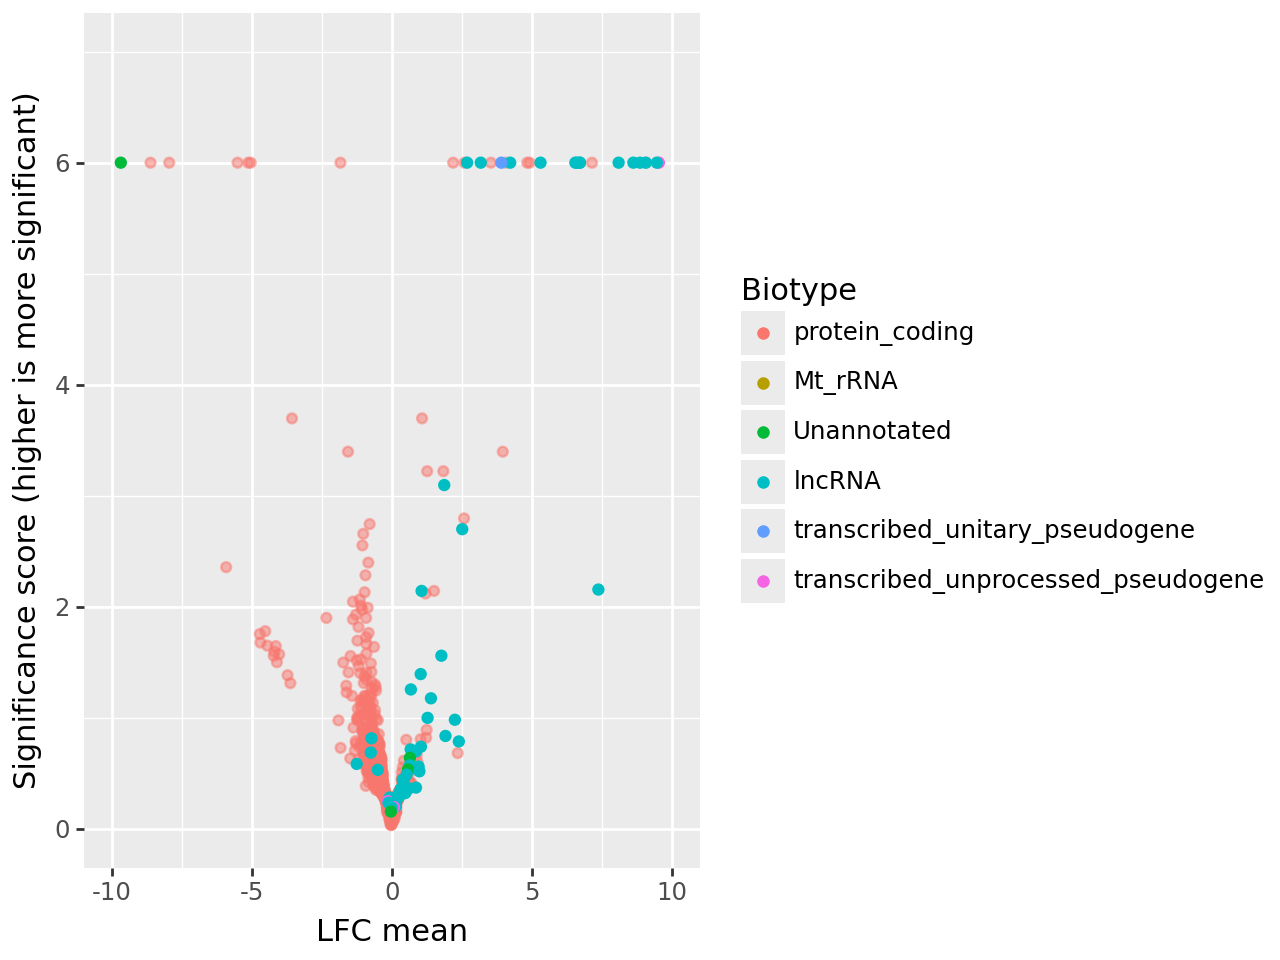

In [20]:
(
    p9.ggplot(de_change, p9.aes("lfc_mean", "-log10_pscore", color="Biotype"))
    + p9.geom_point(
        de_change.query("Biotype == 'protein_coding'"), alpha=0.5
    )  # Plot other genes with transparence
    + p9.xlim(-10, 10)  # Set x limits
    + p9.ylim(0, 7)  # Set y limits
    + p9.geom_point(de_change.query("Biotype != 'protein_coding'"))
    + p9.labs(x="LFC mean", y="Significance score (higher is more significant)")
)

In [21]:
upregulated_genes = de_change.loc[
    de_change["lfc_median"] > 0, ["feature_id", "feature_name"]
].head(4)

Display generated counts from scVI model

/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.


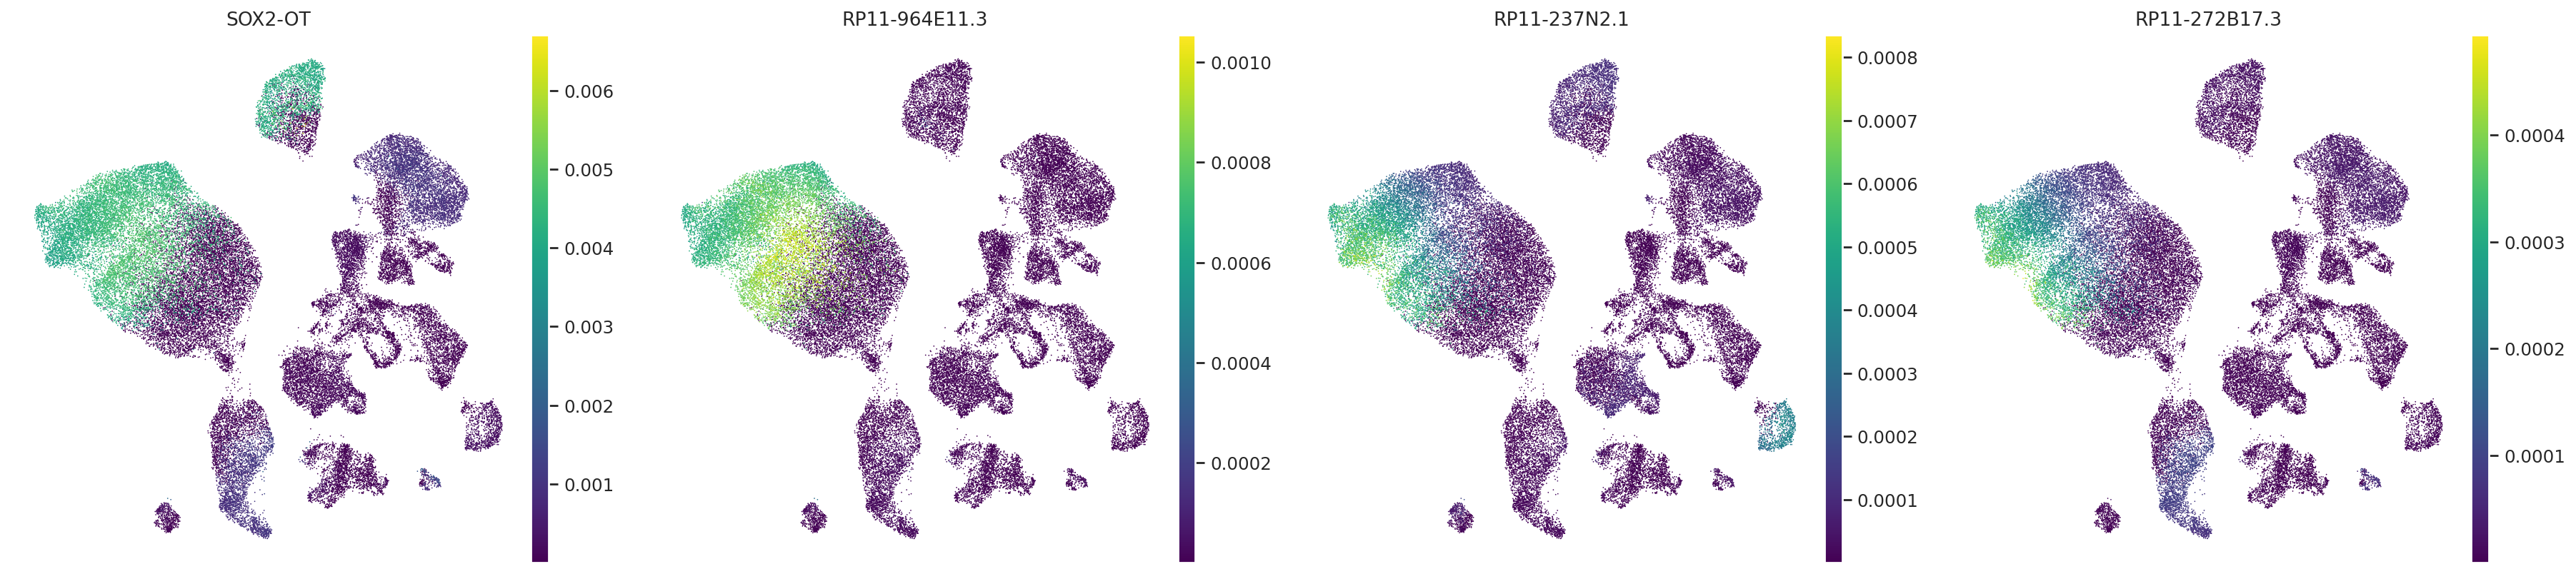

In [22]:
census_model.adata[:, upregulated_genes["feature_id"]] = census_model.get_normalized_expression(
    gene_list=list(upregulated_genes["feature_id"]), n_samples=10
)
sc.pl.umap(
    census_model.adata,
    color=upregulated_genes["feature_name"],
    gene_symbols="feature_name",
    cmap="viridis",
)

## Performing differential expression and yield expression from census

Now we perform DE between each cell type vs all other cells and make a dotplot of the result.

#### Performing differential expression

In [23]:
# here we do a 1-vs-all DE test, which compares each cell type with all others
# this returns the concatenation of all 1 vs all results, contained in a DataFrame
change_per_cluster_de = census_model.differential_expression(
    adata=census_model.adata[census_model.adata.obs["assay"] == "10x 3' v3"],
    groupby="cell_type",
    all_stats=False,
    mode="change",
)

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/scvi/data/fields/_base_field.py:63: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
/opt/anaconda3/envs/scvi_new/lib/python3.13/site-packages/scvi/model/base/_rnamixin.py:429: UserWarning: Count statistics make no sense for minified model. Consider disabling all_stats.


DE...:   0%|          | 0/21 [00:00<?, ?it/s]

In [24]:
cell_types = (
    adata.obs["cell_type"]
    .value_counts()
    # .loc[lambda x: (x >= 500) & (x.index != "nan")]
    .loc[lambda x: x.index != "nan"]
    .to_frame("n_cells")
)
cell_types.loc[:, "associated_test"] = cell_types.index.astype(str) + " vs Rest"

In [25]:
change_per_cluster_de = change_per_cluster_de.join(census_model.adata.var, how="inner")
change_per_cluster_de = change_per_cluster_de[
    change_per_cluster_de[["scale1", "scale2"]].max(axis=1) > 1e-4
]
change_per_cluster_de.head(20)

proba_de  proba_not_de  bayes_factor    scale1    scale2  \
feature_id                                                                  
ENSG00000204929    0.9884        0.0116      4.445082  0.000939  0.000113   
ENSG00000287544    0.9840        0.0160      4.119037  0.000313  0.000015   
ENSG00000151322    0.9824        0.0176      4.022099  0.015489  0.004528   
ENSG00000288560    0.9784        0.0216      3.813225  0.000164  0.000023   
ENSG00000233639    0.9780        0.0220      3.794467  0.000868  0.000143   
ENSG00000236790    0.9774        0.0226      3.766946  0.002097  0.000147   
ENSG00000261404    0.9762        0.0238      3.713981  0.000547  0.000159   
ENSG00000080493    0.9758        0.0242      3.696905  0.003838  0.000327   
ENSG00000287292    0.9740        0.0260      3.623314  0.001743  0.000187   
ENSG00000273118    0.9720        0.0280      3.547151  0.000380  0.000086   
ENSG00000145476    0.9704        0.0296      3.489934  0.000222  0.000098   
ENSG00000091138    0.9700        0.0300      3.476098  0.000005  0.000301   
ENSG00000083067    0.9694        0.0306      3.455677  0.016102  0.001976   
ENSG00000234377    0.9662        0.0338      3.352910  0.006446  0.000491   
ENSG00000231304    0.9634        0.0366      3.270420  0.000430  0.000079   
ENSG00000164089    0.9616        0.0384      3.220541  0.001599  0.000128   
ENSG00000287158    0.9594        0.0406      3.162540  0.000191  0.000016   
ENSG00000198838    0.9580        0.0420      3.127178  0.005951  0.000640   
ENSG00000251372    0.9564        0.0436      3.088119  0.000488  0.000062   
ENSG00000198963    0.9538        0.0462      3.027474  0.001032  0.000137   

                 pseudocounts  delta   lfc_mean  lfc_median   lfc_std  ...  \
feature_id                                                             ...   
ENSG00000204929  3.200916e-07   0.25   4.635637    4.416831  2.389565  ...   
ENSG00000287544  3.200916e-07   0.25   9.663720    8.085569  4.618678  ...   
ENSG00000151322  3.200916e-07   0.25   2.478718    1.656276  1.884972  ...   
ENSG00000288560  3.200916e-07   0.25   5.707840    4.334204  4.024246  ...   
ENSG00000233639  3.200916e-07   0.25   5.063036    3.226929  3.691148  ...   
ENSG00000236790  3.200916e-07   0.25   6.707326    7.455571  2.670608  ...   
ENSG00000261404  3.200916e-07   0.25   2.333580    1.784798  1.570074  ...   
ENSG00000080493  3.200916e-07   0.25   5.944194    6.824965  2.573866  ...   
ENSG00000287292  3.200916e-07   0.25   7.771810    6.196614  4.915103  ...   
ENSG00000273118  3.200916e-07   0.25   4.649741    2.213397  3.780624  ...   
ENSG00000145476  3.200916e-07   0.25   1.251280    1.289731  0.482151  ...   
ENSG00000091138  3.200916e-07   0.25  -3.930191   -2.347409  2.798681  ...   
ENSG00000083067  3.200916e-07   0.25   5.801075    7.135654  3.094589  ...   
ENSG00000234377  3.200916e-07   0.25   7.251151    7.934378  2.585241  ...   
ENSG00000231304  3.200916e-07   0.25   4.959074    2.800905  3.595532  ...   
ENSG00000164089  3.200916e-07   0.25   7.381253    8.115472  2.559449  ...   
ENSG00000287158  3.200916e-07   0.25  10.063144    8.814186  4.944439  ...   
ENSG00000198838  3.200916e-07   0.25   6.005604    6.995085  2.814702  ...   
ENSG00000251372  3.200916e-07   0.25   4.700628    5.185833  2.178193  ...   
ENSG00000198963  3.200916e-07   0.25   4.358594    4.706037  1.999524  ...   

                   lfc_max  is_de_fdr_0.05                   comparison  \
feature_id                                                                
ENSG00000204929  12.149960            True  Bergmann glial cell vs Rest   
ENSG00000287544  19.936712            True  Bergmann glial cell vs Rest   
ENSG00000151322   9.619658            True  Bergmann glial cell vs Rest   
ENSG00000288560  17.234283            True  Bergmann glial cell vs Rest   
ENSG00000233639  16.205431            True  Bergmann glial cell vs Rest   
ENSG00000236790  12.378292            True  Bergmann glial cell vs Rest   
ENSG0

In [26]:
# This cell extracts list of top 5 upregulated genes for every cell-type
marker_genes = (
    change_per_cluster_de.reset_index()
    .loc[lambda x: x.comparison.isin(cell_types.associated_test.values)]
    .groupby("comparison")
    .apply(
        lambda x: x.sort_values("lfc_mean", ascending=False).iloc[:5]
    )  # Select top 5 DE genes per comparison
    .reset_index(drop=True)[["feature_name", "soma_joinid"]]
    .drop_duplicates()
)

/tmp/ipykernel_106570/3989176659.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


### Download raw counts for these genes from CELLxGENE census

We can download the raw expression only for cells and genes of interest from CELLxGENE census. This drastically improves runtime. It is important to use the same census version used for training the model

In [27]:
census = cellxgene_census.open_soma(census_version="2023-12-15")

In [28]:
# This cell extracts list of top 5 upregulated genes for every cell-type
marker_genes = (
    change_per_cluster_de.reset_index()
    .loc[lambda x: x.comparison.isin(cell_types.associated_test.values)]
    .groupby("comparison")
    .apply(
        lambda x: x.sort_values("lfc_mean", ascending=False).iloc[:5]
    )  # Select top 5 DE genes per comparison
    .reset_index(drop=True)[["feature_name", "soma_joinid"]]
    .drop_duplicates()
)

/tmp/ipykernel_106570/3989176659.py:6: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [30]:
adata = cellxgene_census.get_anndata(
    census=census,
    organism="Homo sapiens",
    var_coords=marker_genes["soma_joinid"].to_list(),
    obs_coords=census_model.adata.obs.loc[
        census_model.adata.obs["assay"] == "10x 3' v3", "soma_joinid"
    ].to_list(),
    column_names={
        "obs": [
            "soma_joinid",
            "dataset_id",
            "assay",
            "cell_type",
            "disease",
            "donor_id",
            "sex",
            "suspension_type",
            "tissue",
            "raw_sum",
            "nnz",
            "raw_mean_nnz",
            "raw_variance_nnz",
            "n_measured_vars",
        ]
    },
)

/tmp/ipykernel_106570/1573711683.py:1: FutureWarning: The argument `column_names` is deprecated and will be removed in a future release. Please use `obs_column_names` and `var_column_names` instead.
/opt/anaconda3/envs/scvi_new/lib/python3.13/functools.py:934: ImplicitModificationWarning: Transforming to str index.
/opt/anaconda3/envs/scvi_new/lib/python3.13/functools.py:934: ImplicitModificationWarning: Transforming to str index.


#### Confirm results of downloading cells and dotplot

Check that census download yields the same cells

In [31]:
adata.var.index = adata.var["feature_id"]

In [32]:
np.all(
    adata.obs["dataset_id"].values
    == census_model.adata.obs.loc[census_model.adata.obs["assay"] == "10x 3' v3", "dataset_id"]
)

np.True_

/tmp/ipykernel_106570/2322672266.py:2: UserWarning: Some cells have zero counts


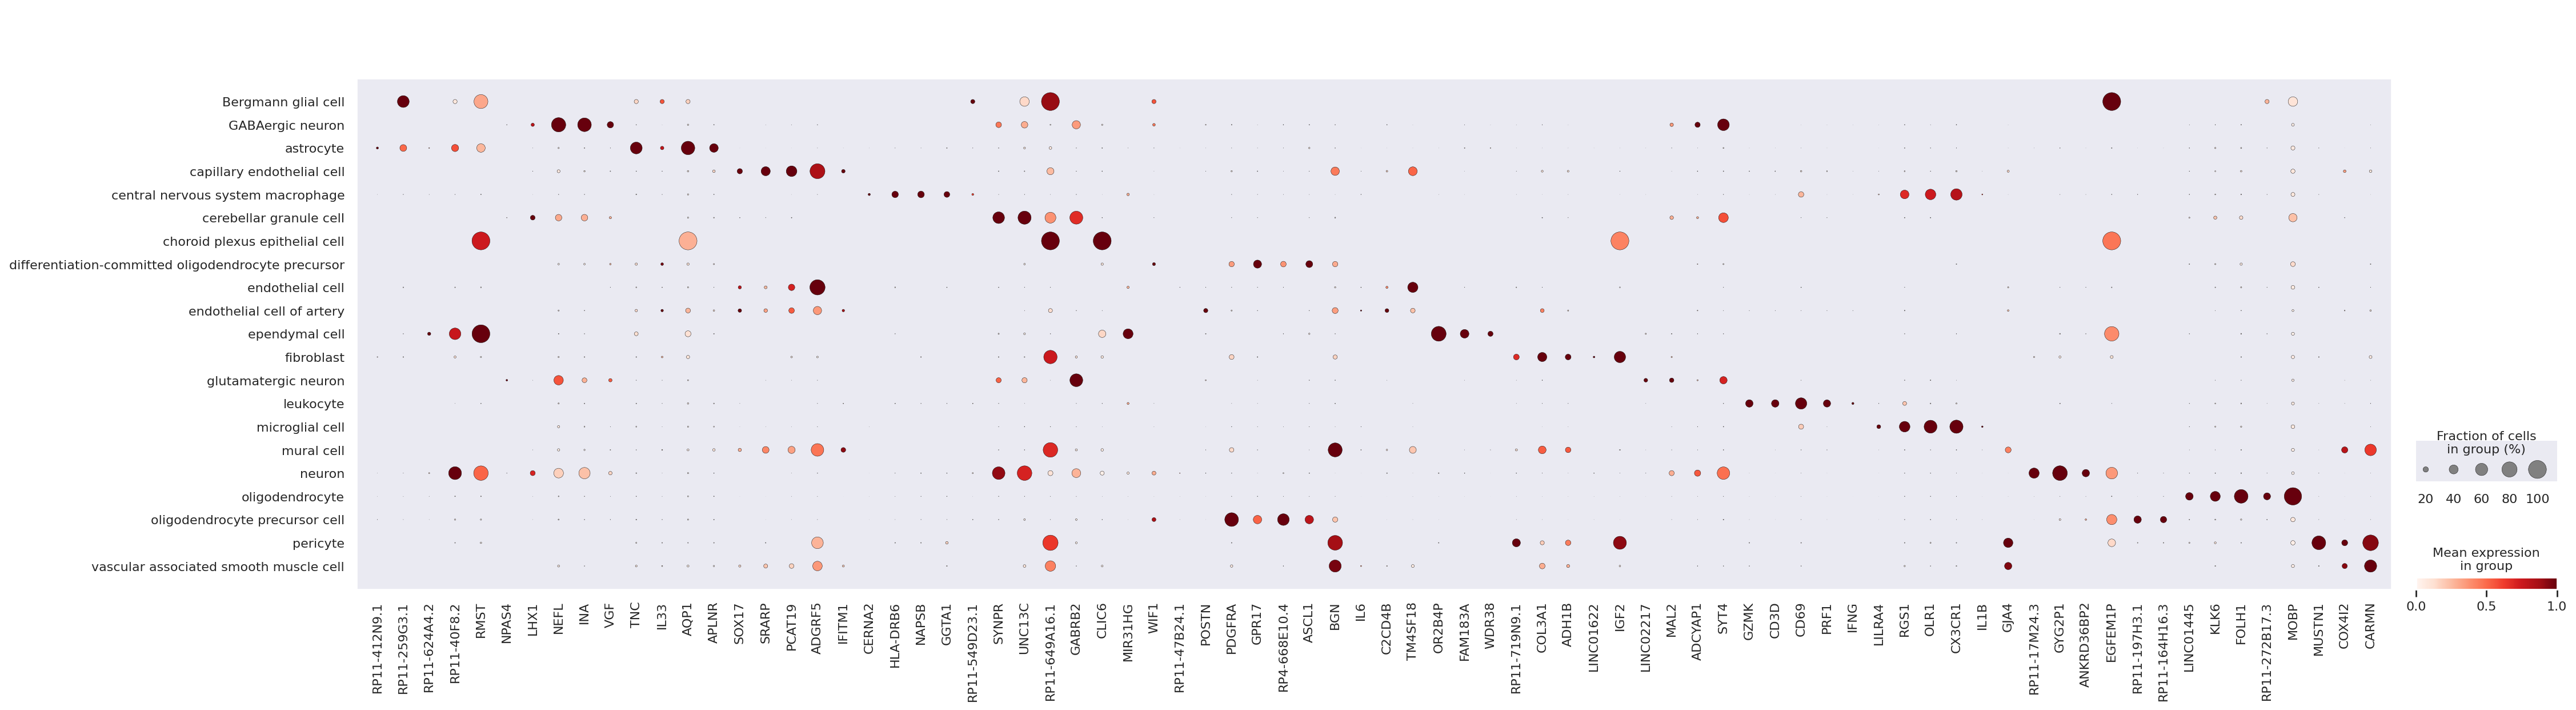

In [33]:
adata_log = adata[adata.obs.cell_type.isin(cell_types.index.values)].copy()
sc.pp.normalize_total(adata_log)
sc.pp.log1p(adata_log)
sc.pl.dotplot(
    adata_log,
    marker_genes["feature_name"].to_list(),
    groupby="cell_type",
    gene_symbols="feature_name",
    standard_scale="var",
)